In [1]:
# Core
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Astronomy
from astropy.time import Time
from astropy.units import deg

# Utility
import os
from datetime import date
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# Libraries for getting Alerce data out of ZTF2 database
import json
import psycopg2
from alerce.api import AlerceAPI

# MSE imports
from utils import range_inc
from astro_utils import date_to_mjd, mjd_to_date
# from ztf_data import load_ztf_det, load_ztf_det_year, ztf_det_add_dir, 
from ztf_data import load_ztf_det_all, ztf_nearest_ast, ztf_obs_by_month, cdf_nearest_dist
from ztf_data import deg2dist, dist2deg, plot_cdf_uncond, plot_cdf_cond
from asteroid_dataframe import spline_ast_vec_dir

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

### Load Detections from Alerce ZTF2 Database

In [3]:
ztf, mjd_unq = load_ztf_det_all()

Loaded ../data/ztf/ztf-detections.h5 from disk.


In [4]:
# Review DataFrame
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504
...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241


In [5]:
# Review data types
ztf.dtypes

ObjectID            |S12
CandidateID        int64
TimeStampID        int32
mjd              float64
ra               float64
dec              float64
ux               float64
uy               float64
uz               float64
mag_app          float64
asteroid_prob    float64
dtype: object

In [6]:
# Sanity check: we should be able to recover the mjd of an observation by indexing into mjd_unq
assert np.all(mjd_unq[ztf.TimeStampID] == ztf.mjd)

### Summarize Observations by Month

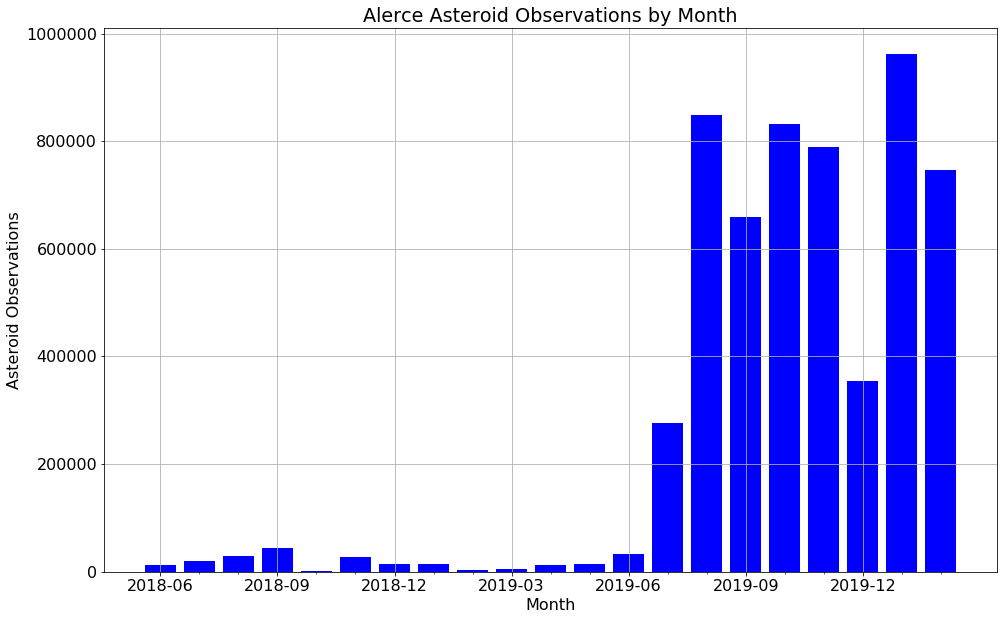

In [7]:
# Generate bar chart
# ztf_obs_by_month(ztf)

# Display the bar chart
Image(filename='../figs/alerce/alerce_ast_per_month.png')

### Extract key Data from ZTF Frame

In [8]:
# Extract mjd, ra, and dec of the ZTF observations as arrays of astropy angles
# mjd_ztf = ztf.mjd.values
# ra_ztf = ztf.ra.values
# dec_ztf = ztf.dec.values

In [9]:
# Extract directions of the ZTF observations as an Nx3 array
# u_ztf = ztf[['ux', 'uy', 'uz']].values

### Load MSE Calculated Asteroid Directions for Comparison to ZTF

In [10]:
# Date range in ZTF data
mjd_min = np.min(mjd_unq)
mjd_max = np.max(mjd_unq)
dt_min = mjd_to_date(mjd_min)
dt_max = mjd_to_date(mjd_max)
print(f'ZTF mjd range : {mjd_min:9.3f} to {mjd_max:9.3f}')
print(f'ZTF date range: {dt_min} to {dt_max}')

ZTF mjd range : 58270.170 to 58905.533
ZTF date range: 2018-06-01 to 2020-02-26


In [11]:
# Range of asteroids to compare to ZTF
n0: int = 1
n1: int = 16
    
# Observatory site
site_name = 'palomar'

In [12]:
# Build splined positions and observations against unique observation times
ast_pos, earth_pos, ast_dir = spline_ast_vec_dir(n0=n0, n1=n1, mjd=mjd_unq, site_name=site_name)

Loading asteroid data from n0=1 to n1=16 in 1 blocks...


In [13]:
# from typing import Optional

In [14]:
ztf, mjd_unq = load_ztf_det_all()

Loaded ../data/ztf/ztf-detections.h5 from disk.


In [15]:
# Find nearest asteroid to ZTF observations
thresh_deg = 180.0
ztf = ztf_nearest_ast(ztf, ast_dir, thresh_deg=thresh_deg, regen=False)

Loaded ../data/ztf/ztf-nearest-ast-1-16.h5 from disk.


In [16]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,12,0.699052,61.598112,20.649155,0.445096,0.895475,-0.003874
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,12,0.770994,58.891852,23.664971,0.473209,0.879148,0.056332
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,12,0.797184,65.603819,23.890308,0.377655,0.925067,0.040346
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,12,0.800647,66.042074,23.799533,0.371535,0.927655,0.037644
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,12,0.789987,64.373712,23.983663,0.395158,0.917498,0.045250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,2,0.896340,282.462297,7.620330,0.213891,-0.835204,0.506640
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,6,0.885070,206.227017,5.672234,-0.892658,-0.364161,0.265610
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,6,0.916657,206.227017,5.672234,-0.892658,-0.364161,0.265610
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,2,0.458190,282.460465,7.619587,0.213861,-0.835217,0.506632


### Analyze Distribution of Nearest Asteroid Distance

In [26]:
# Convert threshold from degrees to cartesian distance
# thresh_rad = np.deg2rad(thresh_deg)
# thresh_dist = np.sin(thresh_rad/2.0)*2.0
thresh_close_deg = 10.0 / 3600
thresh_dist = deg2dist(thresh_close_deg)

# Count number of asteroids matched against
ast_nums = np.unique(ast_dir.asteroid_num)
ast_count = ast_nums.size
# Number of rows in data
N_obs = ztf.shape[0]

# Count frequency of matches
is_close = ztf.nearest_ast_dist < thresh_dist
match_frac_obs = np.mean(is_close)
match_frac_ran = cdf_nearest_dist(dist=thresh_dist, n=ast_count)
match_count_obs = np.sum(is_close)
match_count_ran = N_obs * match_frac_ran
match_ratio = match_frac_obs / match_frac_ran

print(f'Testing {ast_count} asteroids at threshold = {thresh_close_deg} degrees.')
print(f'Observed match count = {match_count_obs:6d}')
print(f'Random   match count = {match_count_ran:6.0f}')
print(f'Observed match fraction = {match_frac_obs:8.6f}')
print(f'Random   match fraction = {match_frac_ran:8.6f}')
print(f'Ratio =  {match_ratio:8.6f}')

Testing 16 asteroids at threshold = 0.002777777777777778 degrees.
Observed match count =     69
Random   match count =      0
Observed match fraction = 0.000012
Random   match fraction = 0.000000
Ratio =  1288.011783


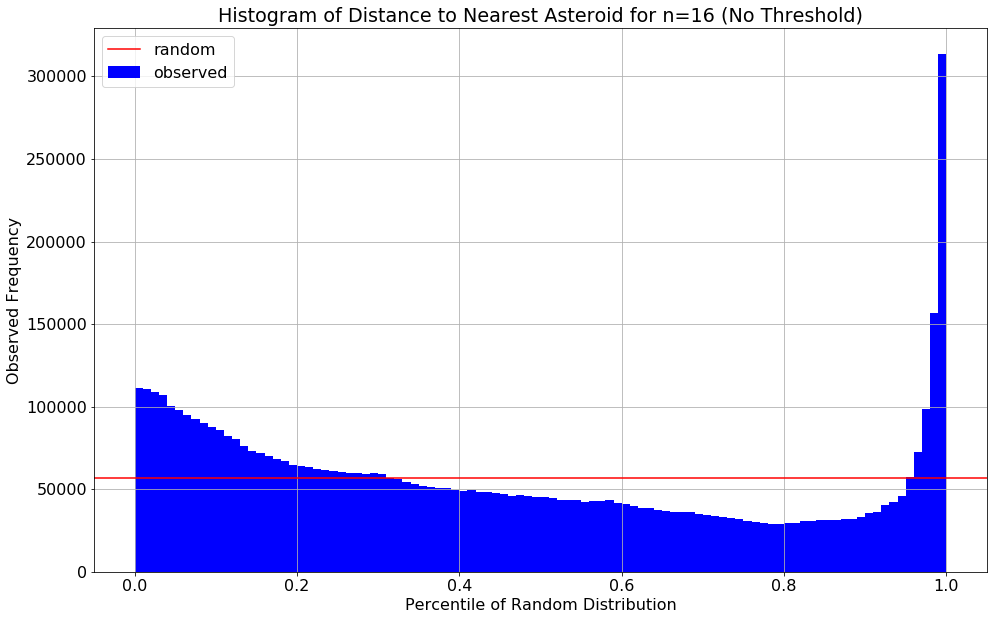

In [18]:
# Plot the unconditional distribution
fig, ax = plot_cdf_uncond(ztf=ztf, n=ast_count, bins=100)

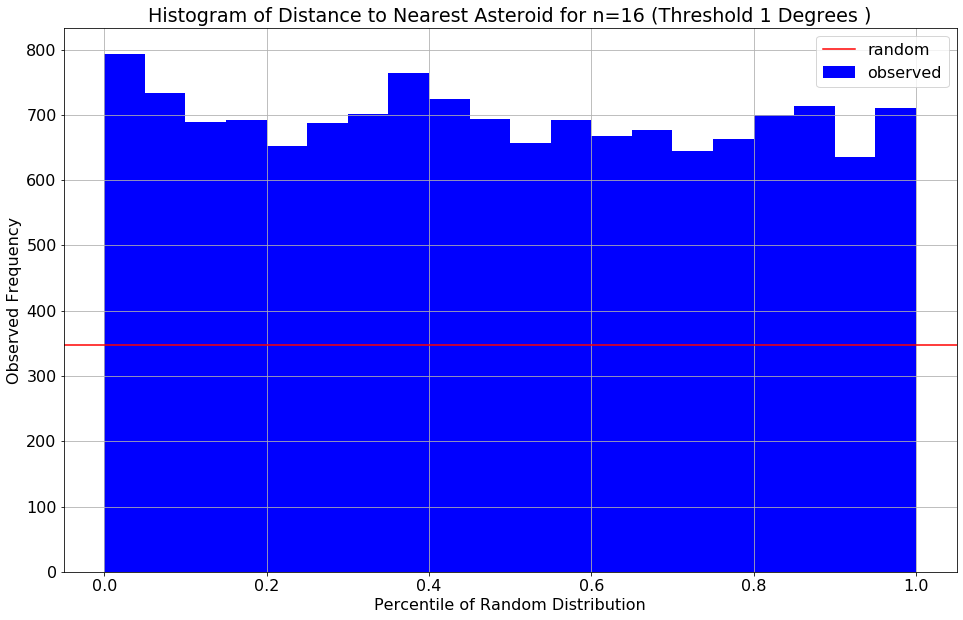

In [19]:
# Plot the conditional distribution at a threshold of 1.0 degrees
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=1.0, bins=20)

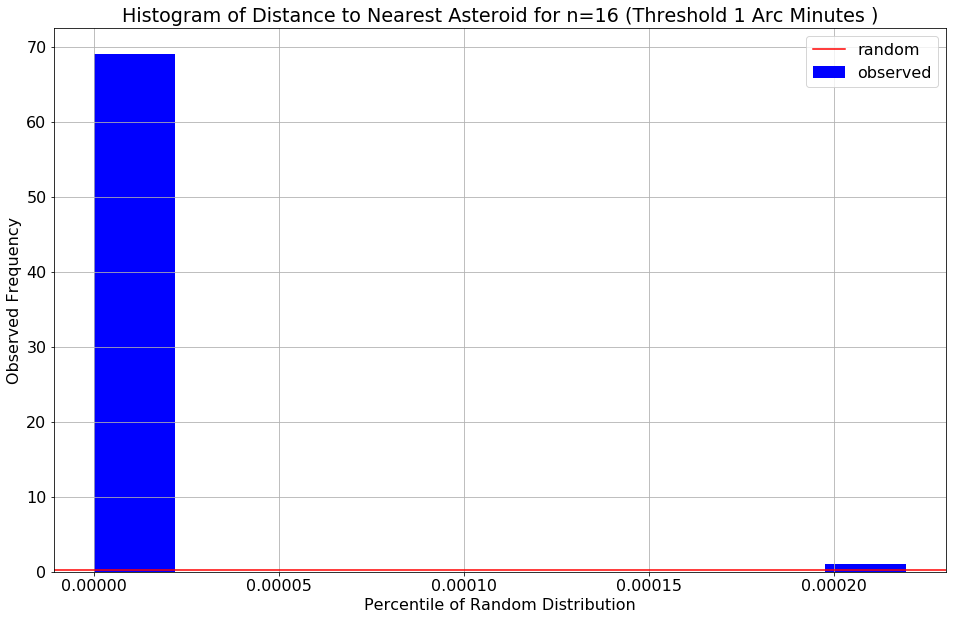

In [24]:
# Plot the conditional distribution at a threshold of 1 arc minute
thresh_one_min = 1.0 / 60
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_min, bins=10)

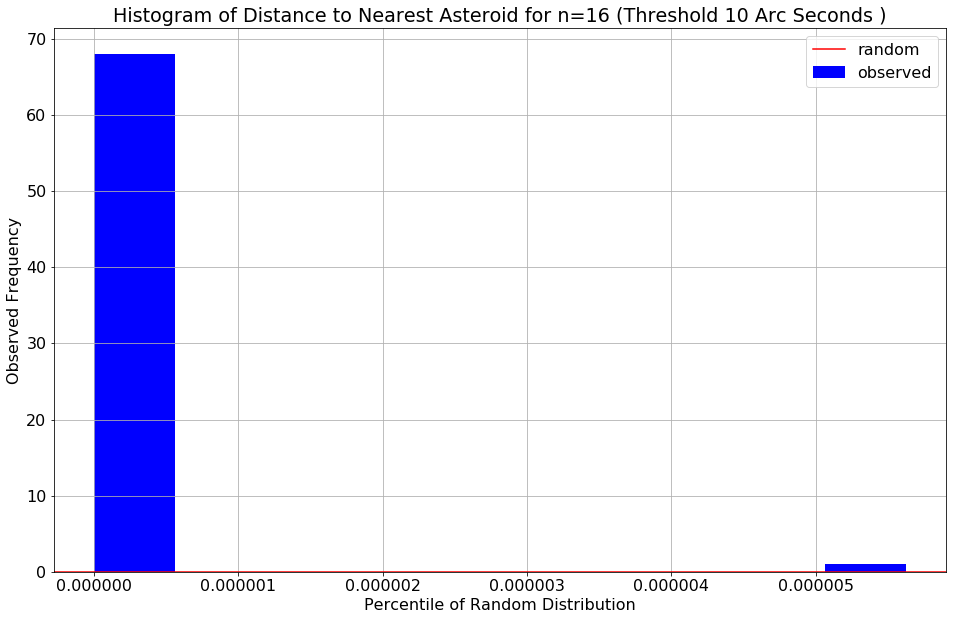

In [25]:
# Plot the conditional distribution at a threshold of 10 arc seconds
thresh_ten_sec = 10.0 / 3600
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=10)